# Data Science Brasil - Desafio Kaggle - Titanic
## Equipe:
* Ricardo Galiardi 
* Wanderson Henrique dos Santos
* Neri Silvestre Filho

In [ ]:
# Caso alguma biblioteca não esteja instalada (descomente a linha)

# Importando xgboost
#!pip install xgboost

# Caso seja necessário atualizar o pacote scikit
#!pip install --force-reinstall scikit-learn==0.20rc1

# Referências

__[score 0.9751](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook)__

__[score 0.8134](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html)__

In [1]:
# Importando os módulos das bibliotecas de Data Science

import sys
import IPython 
from IPython import display

import numpy as np
import pandas as pd      

import sklearn as sk
import scipy as sp

import matplotlib as plt   
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import Functions as fn
import fn_Titanic as fnt

# Faz com que os relatórios (plots) sejam apresentados em uma célula e não em uma nova janela
%matplotlib inline       

In [2]:
# Checando as versões para acompanhamento de atualizações

print("Python version: {}". format(sys.version))
print("NumPy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(plt.__version__))
print("SciPy version: {}". format(sp.__version__)) 
print("scikit-learn version: {}". format(sk.__version__))
print("IPython version: {}". format(IPython.__version__)) 

Python version: 3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
NumPy version: 1.15.4
pandas version: 0.23.4
matplotlib version: 2.2.3
SciPy version: 1.1.0
scikit-learn version: 0.19.2
IPython version: 6.5.0


In [45]:
# Prepara os dados - importando os datasets

dsTrain = pd.read_csv('train.csv', 
                      names=['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], 
                      sep=',', header=0)

dsTest  = pd.read_csv('test.csv',  
                      names=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], 
                      sep=',', header=0)

In [46]:
# Verificando os primeiros registros de Treino

dsTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
# Obtendo as informações do dataset de Treino

dsTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [48]:
# Verificando os dados missing do dataset de Treino

dsTrain.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [49]:
# Cria um dataset com os dois datasets: Treino e de Testes para podermos tratar as variáveis de uma só vez

# Cria novos datasets com a coluna do tipo: treino: 0 e teste: 1
mTrain = dsTrain.copy(deep = True)
mTest = dsTrain.copy(deep = True)

# Incluíndo as colunas de checagem
mTrain['Type'] = 'Train'
mTrain['FamilySize'] = 1
mTrain['IsAlone'] = 1

mTest['Type'] = 'Test'
mTest['FamilySize'] = 1
mTest['IsAlone'] = 1

# Cria uma junção dos dados de treino e teste dados
#dsCombined = mTrain.append(mTest, ignore_index=True, sort=False)
dsCombined = [mTrain, mTest]

dsCombined

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 5              6         0       3   
 6              7         0       1   
 7              8         0       3   
 8              9         1       3   
 9             10         1       2   
 10            11         1       3   
 11            12         1       1   
 12            13         0       3   
 13            14         0       3   
 14            15         0       3   
 15            16         1       2   
 16            17         0       3   
 17            18         1       2   
 18            19         0       3   
 19            20         1       3   
 20            21         0       2   
 21            22         1       2   
 22            23         1       3   
 23            24         1       1   
 24            25        

In [50]:
# Remove as colunas que não serão usadas pelo modelo

drop_column = ['PassengerId','Cabin', 'Ticket']
mTrain.drop(drop_column, axis=1, inplace = True)

In [51]:
# Limpeza dos dados e tratamento de dados missing
## Pela avaliação teremos que tratar as colunas: Age e Embarked, não iremos tratar Cabin, por não ser relevante
## E criar novos campos de tratamento

for dataset in dsCombined:
    #Pclass
    dataset['Pclass'].astype(int)

    #SibSp and Parch
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    #Size
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0

    #Embarked
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #Fare
    dataset['Fare'].fillna(dataset['Fare'].notna().median())

    #Age
    dataset['Age'].fillna(dataset['Age'].notna().median())

    #Title
    #fnt.getTitles(dataset)

In [52]:
# Normalização dos dados

for dataset in dsCombined:
    # Mapeando Sex
    fn.setSex(dataset, 'Sex')

    # Mapeando Fare
    fn.setFare(dataset, 'Fare')

    # Mapeando Age
    fn.setAge(dataset, 'Age')
    
    # Mapeando Title
    fn.setTitle(dataset, 'Name', 'Title')
    
    # Mapeando Embarked
    fn.setEmbarked(dataset, 'Embarked')

In [55]:
# Cria colunas binárias para as colunas numéricas
## Embarked, FamilySize, Title, Cabin, 

#for dataset in dsCombined:
#    # Separando o Embarque
#    fnt.process_embarked(dataset)
#
#    # Separando a Cabine
#    fnt.process_cabin(dataset)
#
#    # Separando as classes
#    fnt.process_pclass(dataset)
#
#    # Separando as classes de familia
#    fnt.process_family(dataset)

In [56]:
dsCombined[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
Type          891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Sex_          891 non-null int32
Fare_         891 non-null int64
Age_          891 non-null int64
Title         891 non-null int64
Embarked_     891 non-null int32
dtypes: float64(2), int32(2), int64(9), object(4)
memory usage: 111.5+ KB


In [57]:
mTrain.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Type,FamilySize,IsAlone,Sex_,Fare_,Age_,Title,Embarked_
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Train,2,0,1,1,4,12,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Train,2,0,0,4,5,13,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Train,1,1,0,1,4,14,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Train,2,0,0,3,4,13,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Train,1,1,1,1,4,12,0


In [58]:
mTest.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,FamilySize,IsAlone,Sex_,Fare_,Age_,Title,Embarked_
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Test,2,0,1,1,4,12,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Test,2,0,0,4,5,13,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Test,1,1,0,1,4,14,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Test,2,0,0,3,4,13,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Test,1,1,1,1,4,12,0


In [62]:
# Definição das classes de variáveis aplicaveis aos modelos

# Define a variável preditora
Target = ['Survived']

# Define as variáveis independente da seleção original
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 
data1_x_calc = ['Sex_','Pclass', 'Embarked_', 'Title', 'SibSp', 'Parch', 'Age_', 'Fare_', 'FamilySize'] 
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


# Define as variáveis independentes quer serão removidas do dataset
data1_x_bin = ['Sex', 'Age', 'Embarked', 'Type']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(mTrain[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex', 'Age', 'Embarked', 'Type'] 

Dummy X Y:  ['Survived', 'Pclass', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'] 



In [63]:
mTrain.describe(include = 'all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Type,FamilySize,IsAlone,Sex_,Fare_,Age_,Title,Embarked_
count,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,891,2,NaN,NaN,NaN,NaN,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",male,NaN,NaN,NaN,NaN,S,Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,577,NaN,NaN,NaN,NaN,646,891,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.383838,2.308642,NaN,NaN,23.699966,0.523008,0.381594,32.204208,NaN,NaN,1.904602,0.602694,0.647587,2.005612,3.175084,12.506173,0.361392
std,0.486592,0.836071,NaN,NaN,17.731181,1.102743,0.806057,49.693429,NaN,NaN,1.613459,0.489615,0.477990,1.049865,1.845945,1.578193,0.635673
min,0.000000,1.000000,NaN,NaN,-0.500000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,NaN,6.000000,0.000000,0.000000,7.910400,NaN,NaN,1.000000,0.000000,0.000000,1.000000,2.000000,12.000000,0.000000
50%,0.000000,3.000000,NaN,NaN,24.000000,0.000000,0.000000,14.454200,NaN,NaN,1.000000,1.000000,1.000000,2.000000,4.000000,12.000000,0.000000
75%,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,31.000000,NaN,NaN,2.000000,1.000000,1.000000,3.000000,4.000000,13.500000,1.000000


In [44]:
# Seleção das variáveis que não serão usadas pelo modelo

#drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
train = dsCombined.loc[dsCombined['Type'] == 'Train']
drop_elements = ['Name', 'Ticket', 'Type']
train = train.drop(drop_elements, axis = 1)
test = dsCombined.loc[dsCombined['Type'] == 'Test']
drop_elements = ['Survived', 'Name', 'Ticket', 'Type']
test = test.drop(drop_elements, axis = 1)

train.describe(include = 'all')

AttributeError: 'list' object has no attribute 'loc'

In [64]:
#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation

from sklearn import model_selection

train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(mTrain[data1_x_calc], mTrain[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(mTrain[data1_x_bin], mTrain[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], mTrain[Target], random_state = 0)


print("Data1 Shape: {}".format(mTrain.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 17)
Train1 Shape: (668, 9)
Test1 Shape: (223, 9)


,Sex,Age,Embarked,Type
105,male,28.0,S,Train
68,female,17.0,S,Train
253,male,30.0,S,Train
320,male,22.0,S,Train
706,female,45.0,S,Train


In [65]:
# Análise Exploratória e Estatística por Tabela

for x in data1_x:
    if mTrain[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(mTrain[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        

#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(mTrain['Title'], mTrain[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0       0  0.000000
1       1  0.500000
2       2  0.500000
3       3  0.000000
4       4  0.000000
5       5  1.000000
6       6  0.428571
7       7  0.000000
8       8  1.000000
9       9  1.000000
10     10  1.000000
11     11  1.000000
12     12  0.156673
13     13  0.792000
14     14  0.697802
15     15  0.575000
16     16  1.000000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  S

In [ ]:
# Análise Exploratória e Estatística por Gráfico
#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix


plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=mTrain['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(mTrain['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(mTrain['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [mTrain[mTrain['Survived']==1]['Fare'], mTrain[mTrain['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [mTrain[mTrain['Survived']==1]['Age'], mTrain[mTrain['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [mTrain[mTrain['Survived']==1]['FamilySize'], mTrain[mTrain['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

In [ ]:
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

#sns.barplot(x = 'Embarked', y = 'Survived', data = mTrain, ax = saxis[0,0])
#sns.barplot(x = 'Pclass', y = 'Survived', order = [1,2,3], data = mTrain, ax = saxis[0,1])
#sns.barplot(x = 'IsAlone', y = 'Survived', order = [1,0], data = mTrain, ax = saxis[0,2])

sns.pointplot(x = 'Fare_', y = 'Survived',  data = mTrain, ax = saxis[1,0])
#sns.pointplot(x = 'Age_', y = 'Survived',  data = mTrain, ax = saxis[1,1])
#sns.pointplot(x = 'FamilySize', y = 'Survived', data = mTrain, ax = saxis[1,2])

In [ ]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = mTrain, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = mTrain, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = mTrain, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

In [ ]:
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data = mTrain, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data = mTrain, ax = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data = mTrain, ax = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

In [ ]:
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

#how does family size factor with sex & survival compare
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=mTrain,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=mTrain,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

In [ ]:
e = sns.FacetGrid(mTrain, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

In [ ]:
a = sns.FacetGrid(mTrain, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , mTrain['Age'].max()))
a.add_legend()

In [ ]:
h = sns.FacetGrid(mTrain, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

In [ ]:
pp = sns.pairplot(mTrain, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

In [ ]:
# Verificando a correlação entre as variáveis do dataset de Treino (Primeira validação)

def correlation_heatmap(data):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        data.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    
correlation_heatmap(mTrain)

In [ ]:
mTrain[data1_x_calc].head()

In [78]:
# Importação dos classificadores

# Suprime erros
import warnings
warnings.filterwarnings('ignore')

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier

# Comparação dos classificadores

classifiers = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

splits = 2
cols = ["Classifier", "Accuracy"]
acc_dict = {}
log = pd.DataFrame(columns=cols)

#cross = KFold(n_splits=splits, random_state=42, shuffle=True)
cross = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0 )

X = mTrain[data1_x_calc]
y = mTrain[Target]

acc_dict = {}

for train_index, test_index in cross.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=cols)
    log = log.append(log_entry)

KeyError: 0

,
Classifier,Accuracy
XGBClassifier,0.414552
GradientBoostingClassifier,0.414552
NuSVC,0.407463
SVC,0.407090
AdaBoostClassifier,0.403731
RandomForestClassifier,0.402985
GaussianProcessClassifier,0.402239
ExtraTreesClassifier,0.401119
BaggingClassifier,0.398507


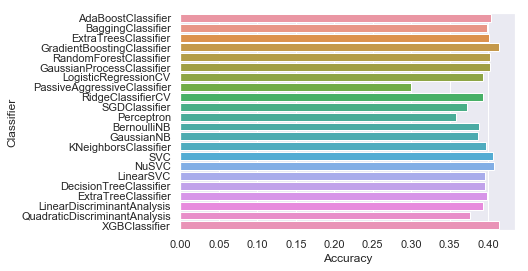

In [76]:
# Plot Classifier Accuracy

sns.set(style="darkgrid")
sns.barplot(x='Accuracy', y='Classifier', data=log)

log.groupby(['Classifier', 'Accuracy']).count().sort_values(by=['Accuracy'], ascending=False)

In [71]:
mTest.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,FamilySize,IsAlone,Sex_,Fare_,Age_,Title,Embarked_
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Test,2,0,1,1,4,12,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Test,2,0,0,4,5,13,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Test,1,1,0,1,4,14,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Test,2,0,0,3,4,13,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Test,1,1,1,1,4,12,0


In [72]:
# Prediction

from sklearn.model_selection import KFold, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

classifier = DecisionTreeClassifier()
classifier.fit(mTrain[Target], mTrain[data1_x_calc])
predictions = classifier.predict(mTest)

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(mTrain[Target], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [ ]:
#Machine Learning Algorithm (MLA) Selection and Initialization

#misc libraries
import random
import time
from subprocess import check_output

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = mTrain[Target]

#index through MLA and save performance to table
row_index = 0

lasso = linear_model.Lasso()
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    #cv_results = model_selection.cross_validate(alg, mTrain[data1_x_bin], mTrain[Target], cv = cv_split)
    cv_results = model_selection.cross_validate(lasso, mTrain[data1_x_bin], mTrain[Target], cv = 3)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(mTrain[data1_x_bin], mTrain[Target])
    MLA_predict[MLA_name] = alg.predict(mTrain[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

In [ ]:
# Treino - Criando os arrays de X e y, com as variáveis independentes e a variável predictora

X_train = train.iloc[0::, 2::]
y_train = train.iloc[0::, 1]

In [ ]:
# Teste - Criando os arrays de X e y, com as variáveis independentes e a variável predictora

X_test = test.iloc[0::, 1::]

In [ ]:
# Split de treino

# Importando a biblioteca que faz o split dos dados
#from sklearn.model_selection import train_test_split

# Separando os dados
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=101)

In [ ]:
# Criando e treinando o modelo

# Importando a biblioteca que faz Regressão linear
## A regressão, em geral, tem como objectivo tratar de um valor que não se consegue estimar inicialmente.
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

In [ ]:
# Predições do nosso modelo e sua visão atráves do gráfico

predictions = lm.predict(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier

classifier = RandomForestClassifier(n_estimators=50, max_features='sqrt')
predictions = classifier.fit(X_train, y_train)

In [ ]:
# Cria a matriz de Confusao: Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')
predictions = cross_val_predict(classifier, X_train, y_train, cv=3)
pd.DataFrame(confusion_matrix(y_train, predictions), columns=['true', 'false'], index=['true', 'false'])

In [ ]:
# Histograma residual

sns.distplot((y_test-predictions), bins=50)

## Métricas de avaliação de regressão


Aqui estão três métricas de avaliação comuns para problemas de regressão:

**Mean absolute error ** (erro absoluto médio) (MAE) é a média do valor absoluto dos erros:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

** Mean Squared Error ** (erro médio quadrático) (MSE) é a média dos erros quadrados:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

** Root Mean Square Error ** (raiz do erro quadrático médio) (RMSE) é a raiz quadrada da média dos erros quadrados:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparando estas métricas:

- **MAE** é o mais fácil de entender, porque é o erro médio.
- **MSE** é mais popular que o MAE, porque a MSE "puniria" erros maiores, o que tende a ser útil no mundo real.
- **RMSE** é ainda mais popular do que MSE, porque o RMSE é interpretável nas unidades "y".

Todas estas são ** funções de perda **, porque queremos minimizá-las.

In [ ]:
# Avaliando a métrica de avaliação da Regressão

# Importando a biblioteca que faz a Métrica
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
# Importação dos classificadores

# Suprime erros
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBClassifier

In [ ]:
# Cria a Comparação dos classificadores

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100, oob_score = True),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    LinearRegression(),
    XGBClassifier()]

splits = 2
cols = ["Classifier", "Accuracy"]
acc_dict = {}
log = pd.DataFrame(columns=cols)
count = 0

#shuff = KFold(n_splits=splits, random_state=42, shuffle=True)
#shuff = ShuffleSplit(n_splits=splits, test_size=0.3, random_state=0)
#shuff = StratifiedShuffleSplit(n_splits=splits, test_size=0.4, random_state=0)

#for train_index, test_index in shuff.split(X, y):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    count += 1
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=cols)
    log = log.append(log_entry)
    
acc_dict

In [ ]:
# Verifica a acurácia por tipo de classificação

sns.set(style="darkgrid")
sns.barplot(x='Accuracy', y='Classifier', data=log)

log.groupby(['Classifier', 'Accuracy']).count().sort_values(by=['Accuracy'], ascending=False)

In [ ]:
# Com base no melhor classificador, é gerada a Predicção.

classifier = XGBClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [ ]:
# Cria a matriz de Confusao: Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')
predictions = cross_val_predict(classifier, X_train, y_train, cv=3)
pd.DataFrame(confusion_matrix(y_train, predictions), columns=['true', 'false'], index=['true', 'false'])

In [ ]:
# Cria o Dataframe com os dados para envio ao Kaggle

dssubmission = pd.DataFrame({'PassengerId': ds['PassengerId'], 'Survived': predictions})

In [ ]:
# Converte o DataFrame para um arquivo csv para envio ao Kaggle
filename = 'kaggle_titanic.csv'

dssubmission.to_csv(filename, index=False)